<a href="https://colab.research.google.com/github/RicardoBolanho/Qoda_Aula_01/blob/main/Streamlit_DataApp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PRIMEIRO DATA APP: COVID-19

In [ ]:
!pip install streamlit
!pip install pyngrok==4.1.1

In [ ]:
%%writefile app.py
# -*- coding: utf-8 -*-
import pandas as pd
import streamlit as st
import altair as alt #https://altair-viz.github.io/

@st.cache(allow_output_mutation=True)
def get_df(type, by="global"):
    path = f"https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_{type}_{by}.csv"
    df = pd.read_csv(path)
    return get_country_df(df, type)

def get_country_df(df, type):
    cols = ["Lat", "Long", "Province/State"]
    df = df.drop(columns=cols).rename(columns={"Country/Region": "country"})
    df["country"] = df["country"].replace({"US": "United States", "Korea, South": "South Korea"})
    df = df.melt(id_vars="country", var_name="date", value_name=f"total_{type}".lower())
    df["date"] = pd.to_datetime(df["date"])
    df = df.set_index("date").groupby("country").resample("D").sum().reset_index()
    df[f"daily_{type}"] = df.groupby("country")[f"total_{type}"].diff().fillna(0).clip(lower=0)
    return df

def days_since(df, col, num=100, groupby="country"):
    df["days_since"] = df.assign(t=df[col] >= num).groupby(groupby)["t"].cumsum()
    return df[df["days_since"] > 0]

def chart(df, y, color="country"):
    return (
        alt.Chart(df, width=750, height=500)
        .mark_line(point=True)
        .encode(
            x="days_since",
            y=alt.Y(y),
            color=color,
            tooltip=[alt.Tooltip(color), alt.Tooltip(y, format=",")],
        )
        .interactive()
    )

def main():
    by = st.radio("Choose Analysis", ["Country", "State"])
    by = by.lower()

    if by == "country":
        confirmed_df = get_df("confirmed", "global")
        deaths_df = get_df("deaths", "global")
    else:
        confirmed_df = get_df("confirmed", "US")
        deaths_df = get_df("deaths", "US")

    chart_type = st.radio("Choose Chart Type", ["Cumulative", "Daily"])

    num_confirmed = st.text_input("Number of Confirmed:", 100)
    confirmed_since_df = days_since(
        confirmed_df, "total_confirmed", num=int(num_confirmed), groupby=by
    )

    top_5 = (
        confirmed_since_df.groupby(by)["total_confirmed"]
        .max()
        .sort_values(ascending=False)
        .head(5)
        .index.tolist()
    )

    select_all = confirmed_since_df[by].unique().tolist()
    radio = st.radio("", ["Top 5", "Select All"])

    if radio == "Top 5":
        multi = st.multiselect("", select_all, default=top_5)
    elif radio == "Select All":
        multi = st.multiselect("", select_all, default=select_all)

    confirmed_since_df = confirmed_since_df[confirmed_since_df[by].isin(multi)]

    st.markdown(f"## Confirmed cases by days since {num_confirmed} confirmed 😷")
    if chart_type == "Cumulative":
        st.altair_chart(chart(confirmed_since_df, "total_confirmed", color=by))
    else:
        st.altair_chart(chart(confirmed_since_df, "daily_confirmed", color=by))

    num_deaths = st.text_input("Number of Death(s):", 1)
    deaths_since_df = days_since(deaths_df, "total_deaths", num=int(num_deaths), groupby=by)
    deaths_since_df = deaths_since_df[deaths_since_df[by].isin(multi)]

    st.markdown(f"## Deaths by days since {num_deaths} death(s)")
    if chart_type == "Cumulative":
        st.altair_chart(chart(deaths_since_df, "total_deaths", color=by))
    else:
        st.altair_chart(chart(deaths_since_df, "daily_deaths", color=by))

    st.markdown("## Totals")
    df = (
        pd.concat(
            [
                confirmed_df.groupby(by)["total_confirmed"].max(),
                deaths_df.groupby(by)["total_deaths"].max(),
            ],
            axis=1,
        )
        .sort_values("total_deaths", ascending=False)
        .style.format("{:,}")
    )

    st.dataframe(df)

if __name__ == "__main__":
    st.title("COVID-19 🦠")
    main()

Overwriting app.py


In [ ]:
!ls

app.py	sample_data


Atenção: o ideal é você acessar https://dashboard.ngrok.com/get-started/your-authtoken e criar seu authtoken gratuitamente, inserindo logo abaixo o código. Assim você não tera problemas em deploy por outras pessoas ja estarem usando o token abaixo simultaneamente.

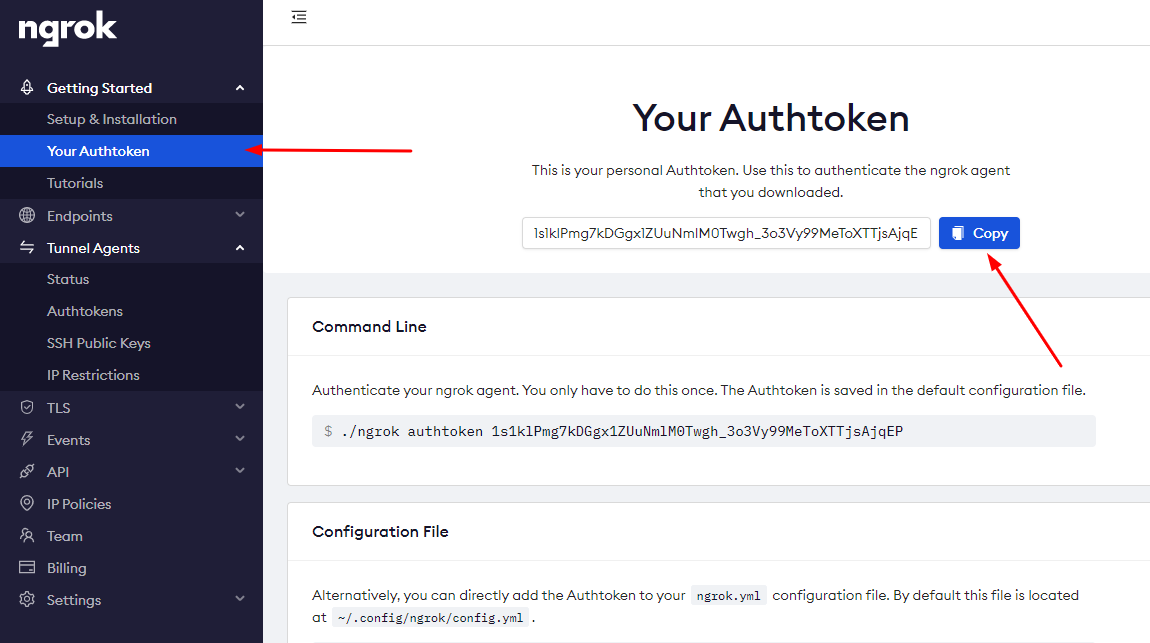

In [ ]:
# TOKEN WEBER: CRIE O SEU OU TERÁ PROBLEMAS NO DEPLOY :)
!ngrok authtoken 1s1klPmg7kDGgx1ZUuNmlM0Twgh_3o3Vy99MeToXTTjsAjqEP

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
!streamlit run app.py &>/dev/null&

In [ ]:
!pgrep streamlit

153
306


In [ ]:
from pyngrok import ngrok
# Setup a tunnel to the streamlit port 8501
public_url = ngrok.connect(port='8501')
public_url

'http://9e86476a51f9.ngrok.io'

# codigo separado

In [ ]:
# -*- coding: utf-8 -*-
import pandas as pd
import streamlit as st
import altair as alt #https://altair-viz.github.io/

In [ ]:
@st.cache(allow_output_mutation=True)
def get_df(type, by="global"):
    path = f"https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_{type}_{by}.csv"
    df = pd.read_csv(path)
    return get_country_df(df, type)

In [ ]:
def get_country_df(df, type):
    cols = ["Lat", "Long", "Province/State"]
    df = df.drop(columns=cols).rename(columns={"Country/Region": "country"})
    df["country"] = df["country"].replace({"US": "United States", "Korea, South": "South Korea"})
    df = df.melt(id_vars="country", var_name="date", value_name=f"total_{type}".lower())
    df["date"] = pd.to_datetime(df["date"])
    df = df.set_index("date").groupby("country").resample("D").sum().reset_index()
    df[f"daily_{type}"] = df.groupby("country")[f"total_{type}"].diff().fillna(0).clip(lower=0)
    return df

In [ ]:
def days_since(df, col, num=100, groupby="country"):
    df["days_since"] = df.assign(t=df[col] >= num).groupby(groupby)["t"].cumsum()
    return df[df["days_since"] > 0]

In [ ]:
def chart(df, y, color="country"):
    return (
        alt.Chart(df, width=750, height=500)
        .mark_line(point=True)
        .encode(
            x="days_since",
            y=alt.Y(y),
            color=color,
            tooltip=[alt.Tooltip(color), alt.Tooltip(y, format=",")],
        )
        .interactive()
    )

In [ ]:
def main():
    by = st.radio("Choose Analysis", ["Country", "State"])
    by = by.lower()

    if by == "country":
        confirmed_df = get_df("confirmed", "global")
        deaths_df = get_df("deaths", "global")
    else:
        confirmed_df = get_df("confirmed", "US")
        deaths_df = get_df("deaths", "US")

    chart_type = st.radio("Choose Chart Type", ["Cumulative", "Daily"])

    num_confirmed = st.text_input("Number of Confirmed:", 100)
    confirmed_since_df = days_since(
        confirmed_df, "total_confirmed", num=int(num_confirmed), groupby=by
    )

    top_5 = (
        confirmed_since_df.groupby(by)["total_confirmed"]
        .max()
        .sort_values(ascending=False)
        .head(5)
        .index.tolist()
    )

    select_all = confirmed_since_df[by].unique().tolist()
    radio = st.radio("", ["Top 5", "Select All"])

    if radio == "Top 5":
        multi = st.multiselect("", select_all, default=top_5)
    elif radio == "Select All":
        multi = st.multiselect("", select_all, default=select_all)

    confirmed_since_df = confirmed_since_df[confirmed_since_df[by].isin(multi)]

    st.markdown(f"## Confirmed cases by days since {num_confirmed} confirmed 😷")
    if chart_type == "Cumulative":
        st.altair_chart(chart(confirmed_since_df, "total_confirmed", color=by))
    else:
        st.altair_chart(chart(confirmed_since_df, "daily_confirmed", color=by))

    num_deaths = st.text_input("Number of Death(s):", 1)
    deaths_since_df = days_since(deaths_df, "total_deaths", num=int(num_deaths), groupby=by)
    deaths_since_df = deaths_since_df[deaths_since_df[by].isin(multi)]

    st.markdown(f"## Deaths by days since {num_deaths} death(s)")
    if chart_type == "Cumulative":
        st.altair_chart(chart(deaths_since_df, "total_deaths", color=by))
    else:
        st.altair_chart(chart(deaths_since_df, "daily_deaths", color=by))

    st.markdown("## Totals")
    df = (
        pd.concat(
            [
                confirmed_df.groupby(by)["total_confirmed"].max(),
                deaths_df.groupby(by)["total_deaths"].max(),
            ],
            axis=1,
        )
        .sort_values("total_deaths", ascending=False)
        .style.format("{:,}")
    )

    st.dataframe(df)

In [ ]:
if __name__ == "__main__":
    st.title("COVID-19 🦠")
    main()